In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [12]:

all_data=[]
Articles_with_stopwords=[]
Articles_without_stopwords=[]
Summaries=[]
stop_words=set(stopwords.words('english'))
for d,path,filenames in tqdm(os.walk('BBC News Summary')):
    for file in filenames:
        if os.path.isfile(d+'/'+file):
            if('Summaries' in d+'/'+file):
                with open(d+'/'+file,'r',errors='ignore') as f:
                    summary=''.join([i.rstrip() for i in f.readlines()])
                    Summaries.append(summary)
                    f.close()
            else:
                with open(d+'/'+file,'r',errors='ignore') as f:
                    Article=''.join([i.rstrip() for i in f.readlines()])
                    Articles_with_stopwords.append(Article)
                    Articles_without_stopwords.append(' '.join([w for w in Article.split() if w not in stop_words]))
                    f.close()
        

26it [00:01, 15.22it/s]


In [13]:
print(len(Articles_with_stopwords),len(Articles_without_stopwords),len(Summaries))

4450 4450 4450


In [14]:
data=pd.DataFrame({'Articles without stop words':Articles_without_stopwords,'Article with stop words': Articles_with_stopwords,'Summary':Summaries})
data.head()


,Articles without stop words,Article with stop words,Summary
0,Ad sales boost Time Warner profitQuarterly pro...,Ad sales boost Time Warner profitQuarterly pro...,TimeWarner said fourth quarter sales rose 2% t...
1,Dollar gains Greenspan speechThe dollar hit hi...,Dollar gains on Greenspan speechThe dollar has...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claimThe owners em...,Yukos unit buyer faces loan claimThe owners of...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profitsBritish Airwa...,High fuel prices hit BA's profitsBritish Airwa...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts DomecqShares UK dri...,Pernod takeover talk lifts DomecqShares in UK ...,Pernod has reduced the debt it took on to fund...


In [18]:
data['Articles without stop words'][0]

'Ad sales boost Time Warner profitQuarterly profits US media giant TimeWarner jumped 76% $1.13bn (Â£600m) three months December, $639m year-earlier.The firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. Its profits buoyed one-off gains offset profit dip Warner Bros, less users AOL.Time Warner said Friday owns 8% search-engine Google. But internet business, AOL, mixed fortunes. It lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL\'s underlying profit exceptional items rose 8% back stronger internet advertising revenues. It hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL\'s existing customers high-speed broadband. TimeWarner also restate 2000 2003 results following probe US Securities Exchange Commission (SEC), close concluding.Time Warner\'s fourth quarter profits sli

In [19]:
for i in range(5):
    print(data['Article with stop words'][i])
    print("---------------------------------------------")

Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's ex

In [20]:
data['Summary'][0]

"TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.Time Warner's fourth quarter profits were slightly better than analysts' expectations."

In [21]:
import re

In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [23]:
def clean_text(text):
    
    text=text.lower()
    text=' '.join([contraction_mapping[i] if i in contraction_mapping.keys() else i for i in text.split()])
    text=re.sub(r'\(.*\)',"",text)
    text=re.sub("'s","",text)
    text=re.sub('"','',text)
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z]'," ",text)
    
    return text

In [24]:
data['Article with stop words']=data['Article with stop words'].apply(clean_text)
data['Articles without stop words']=data['Articles without stop words'].apply(clean_text)
data['Summary']=data['Summary'].apply(clean_text)
data['Summary']='<START> '+data['Summary']+' <END>'

In [25]:
data['Article with stop words'][0]

'ad sales boost time warner profitquarterly profits at us media giant timewarner jumped to which is close to warner fourth quarter profits were slightly better than but its film division saw profits slump to helped by flops alexander and a sharp contrast to when the third and final film in the lord of the rings trilogy boosted for the timewarner posted a profit of up from its while revenues grew to our financial performance was meeting or exceeding all of our objectives and greatly enhancing our chairman and chief executive richard parsons for timewarner is projecting operating earnings growth of around and also expects higher revenue and wider profit is to restate its accounts as part of efforts to resolve an inquiry into aol by us market it has already offered to pay to settle in a deal that is under review by the the company said it was unable to estimate the amount it needed to set aside for legal which it previously set at it intends to adjust the way it accounts for a deal with g

In [26]:
data['Articles without stop words'][0]

'ad sales boost time warner profitquarterly profits us media giant timewarner jumped close warner fourth quarter profits slightly better but film division saw profits slump helped flops alexander sharp contrast third final film lord rings trilogy boosted for timewarner posted profit revenues grew our financial performance meeting exceeding objectives greatly enhancing chairman chief executive richard parsons for timewarner projecting operating earnings growth around also expects higher revenue wider profit restate accounts part efforts resolve inquiry aol us market it already offered pay settle deal review the company said unable estimate amount needed set aside legal previously set it intends adjust way accounts deal german music publisher bertelsmann purchase stake aol reported advertising it book sale stake aol europe loss value'

In [27]:
data['Summary'][0]

'<START> timewarner said fourth quarter sales rose to from the timewarner posted a profit of up from its while revenues grew to profits at us media giant timewarner jumped to for the three months to from the company said aol underlying profit before exceptional items rose on the back of stronger internet advertising profits were buoyed by gains which offset a profit dip at warner and less users for timewarner is projecting operating earnings growth of around and also expects higher revenue and wider profit lost subscribers in the fourth quarter profits were lower than in the preceding three warner fourth quarter profits were slightly better than <END>'

In [28]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.3,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

3115 3115
1335 1335


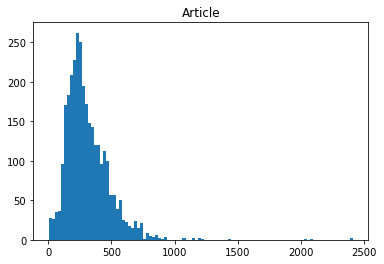

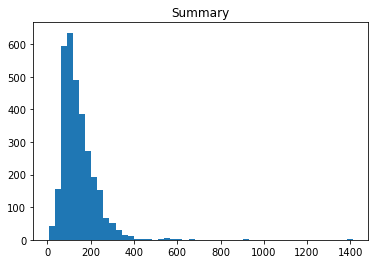

In [29]:
art_len=[len(i.split()) for i in X_train]
sum_len=[len(i.split()) for i in Y_train]
plt.hist(art_len,bins=100)
plt.title('Article')
plt.show()
plt.hist(sum_len,bins=50)
plt.title('Summary')
plt.show()

In [30]:
max_art_len=500
max_sum_len=100

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
article_tokenizer=Tokenizer(oov_token='<UNK>')
article_tokenizer.fit_on_texts(X_train)
tokenized_X_train=article_tokenizer.texts_to_sequences(X_train)
tokenized_X_val=article_tokenizer.texts_to_sequences(X_val)

In [33]:
art_vocab_size=len(article_tokenizer.word_index)+1


In [34]:
padded_X_train=pad_sequences(tokenized_X_train,maxlen=max_art_len,padding='post',truncating='post')
padded_X_val=pad_sequences(tokenized_X_val,maxlen=max_art_len,padding='post',truncating='post')

In [35]:
print(padded_X_train.shape,padded_X_val.shape)

(3115, 500) (1335, 500)


In [36]:
summary_tokenizer=Tokenizer(oov_token='<UNK>')
summary_tokenizer.fit_on_texts(Y_train)
tokenized_Y_train=summary_tokenizer.texts_to_sequences(Y_train)
tokenized_Y_val=summary_tokenizer.texts_to_sequences(Y_val)


In [37]:
sum_vocab_size=len(summary_tokenizer.word_index)+1

In [38]:
padded_Y_train=pad_sequences(tokenized_Y_train,maxlen=max_sum_len,padding='post',truncating='post')
padded_Y_val=pad_sequences(tokenized_Y_val,maxlen=max_sum_len,padding='post',truncating='post')


In [39]:
print(padded_Y_train.shape,padded_Y_val.shape)

(3115, 100) (1335, 100)


In [40]:
reverse_art_index=article_tokenizer.index_word
reverse_sum_index=summary_tokenizer.index_word
sum_wordindex=summary_tokenizer.word_index

In [41]:
encoder_inputs=Input(shape=(max_art_len,))
encoder_emb=Embedding(art_vocab_size,100,trainable=True,name='Encoder_Embedding_layer')(encoder_inputs)
encoder_lstm1=LSTM(300,return_sequences=True,return_state=True,name='Encoder_LSTM1')
enclstm1_outputs,enclstm1_h,enclstm1_c=encoder_lstm1(encoder_emb)


decoder_inputs=Input(shape=(None,))
decoder_em=Embedding(sum_vocab_size,100,trainable=True,name='Decoder_Embedding_layer')
decoder_emb=decoder_em(decoder_inputs)

decoder_lstm1=LSTM(300,return_sequences=True,return_state=True,name='Decoder_LSTM1')
declstm1_output,declstm1_h,declstm1_c=decoder_lstm1(decoder_emb,initial_state=[enclstm1_h,enclstm1_c])

output_layer=TimeDistributed(Dense(sum_vocab_size,activation='softmax',name='softmax'))
output=output_layer(declstm1_output)

model=Model([encoder_inputs,decoder_inputs],output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding_layer (Embedd (None, 500, 100)     2425600     input_1[0][0]                    
__________________________________________________________________________________________________
Decoder_Embedding_layer (Embedd (None, None, 100)    1577600     input_2[0][0]                    
______________________________________________________________________________________________

In [42]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy')

In [43]:
model.fit([padded_X_train,padded_Y_train[:,:-1]],padded_Y_train[:,1:],
          epochs=1,
          validation_data=([padded_X_val,padded_Y_val[:,:-1]],padded_Y_val[:,1:]),
          batch_size=64)

49/49 [==============================] - 261s 5s/step - loss: 7.4950 - val_loss: 6.6782


In [44]:
infencoder_model=Model(inputs=[encoder_inputs],outputs=[enclstm1_outputs,enclstm1_h,enclstm1_c])

infdecoder_model_state_input_h=Input(shape=(300,),name='infdec_I1')
infdecoder_model_state_input_c=Input(shape=(300,),name='infdec_I2')

infdeclstm1_output,infdec_h,infdec_c=decoder_lstm1(decoder_emb,initial_state=[infdecoder_model_state_input_h,
                                                                                                infdecoder_model_state_input_c
                                                                                               ])

infdec_output=output_layer(infdeclstm1_output)                         

infdecoder_model=Model(inputs=[decoder_inputs]+[infdecoder_model_state_input_h,infdecoder_model_state_input_c],
                       outputs=[infdec_output]+[infdec_h,infdec_c])

In [51]:
infencoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
Encoder_Embedding_layer (Emb (None, 500, 100)          2425600   
_________________________________________________________________
Encoder_LSTM1 (LSTM)         [(None, 500, 300), (None, 481200    
Total params: 2,906,800
Trainable params: 2,906,800
Non-trainable params: 0
_________________________________________________________________


In [52]:
plot_model(infencoder_model,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [53]:
infdecoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Decoder_Embedding_layer (Embedd (None, None, 100)    1577600     input_2[0][0]                    
__________________________________________________________________________________________________
infdec_I1 (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
infdec_I2 (InputLayer)          [(None, 300)]        0                                            
____________________________________________________________________________________________

In [54]:
plot_model(infdecoder_model,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [55]:
def decode_sequence(inp_seq):
    
    enc_out,enc_h,enc_c=infencoder_model.predict(inp_seq)
    
    tar_seq=np.zeros((1,1))
    tar_seq[0,0]=sum_wordindex['start']
    
    stop_loop=False
    decoded_string=''
    
    while not stop_loop:
       
        dec_out,dec_h,dec_c=infdecoder_model.predict([tar_seq]+[enc_h,enc_c])
        
        tar_token_index=np.argmax(dec_out[0,-1,:])
        tar_token_word=sum_wordindex[tar_token_index]
        
        if tar_token_word =='end' or len(decoded_string)>=max_art_len:
            
            stop_loop=True
        else:
            decoded_string+=tar_token_word
            
            tar_seq=np.zeros((1,1))
            tar_seq[0,0]=tar_token_index
            
            
            enc_h=dec_h
            enc_c=dec_c
            
    return decoded_string

In [56]:
def seq2art(inp_seq):
    
    art=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        art+=reverse_art_index[inp_seq[i]]+' '
        
    return art


def seq2sum(inp_seq):
    
    summary=''
    
    for i in range(len(inp_seq)):
        
        if inp_seq[i]==0:
            break
        word=reverse_sum_index[inp_seq[i]]
        summary+=word+' '
            
    return summary
        
    

In [57]:
print('Example Articel : '+'\n',seq2art(padded_X_val[2]))
print('Example Summary : '+'\n',seq2sum(padded_Y_val[2]))
print('Predicted Summary : '+'\n',decode_sequence(padded_X_val[2]))

Example Articel : 
 soros group warns of kazakh closethe open society institute is politically the osi adding that it paid the money in the organisation has found itself in trouble after being accused of helping to topple georgia former it denies having any but offices have had to close across the osi shut its office in moscow last year and has withdrawn from uzbekistan and in the ukraine earlier this mr soros who took on the bank of england in the and was pelted by this legal prosecution can be considered an attempt by the government to force soros to cease its activities in kazakhstan and shut its doors for kazakh citizens and the osi osi aims to promote democratic and since the break up of the soviet union in kazakhstan has been dominated by its president nursultan he has powers for while insulting the president and officials has been made a criminal the government controls the printing presses and most radio and tv transmission it operates the country national radio and tv recent e

ValueError: Data cardinality is ambiguous:
  x sizes: 1, 500, 500
Make sure all arrays contain the same number of samples.